<a href="https://colab.research.google.com/github/gabi-bernardoni/Projeto-de-Mineracao-de-Textos/blob/main/embedding_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Implementação de Rede Neural com Embedding_Word2Vec
Embeddings são vetores criados por modelos de aprendizado de máquina com a finalidade de capturar dados significativos sobre cada objeto.

Word2Vec é uma técnica de embedding de palavras que transforma palavras em vetores de características contínuas. Esses vetores capturam relações semânticas e contextuais entre as palavras.

As redes neurais convolucionais (Convolutional neural network ou CNNs) são um subconjunto do aprendizado de máquina utilizadas com mais frequência para tarefas de classificação.



##Funcionamento do Modelo

O modelo funciona da seguinte forma:

Primeiro, carrega os dados das avaliações e sentimentos de um arquivo CSV. Em seguida, limpa o texto das avaliações, removendo caracteres especiais, convertendo tudo para minúsculas e eliminando palavras de parada comuns. Após essa limpeza, os textos são tokenizados e convertidos em sequências de palavras.

O modelo Word2Vec é treinado com essas palavras para criar vetores de palavras (embeddings), que capturam o significado semântico de cada palavra. Esses vetores são usados para inicializar a camada de embeddings da rede neural.

A rede neural convolucional (CNN) é então definida e composta por camadas de convolução, pooling e camadas densas. Ela é treinada usando as sequências de palavras tokenizadas e os rótulos de sentimento.

Word2Vec + CNN: Utiliza o Word2Vec para transformar palavras em vetores e treina uma rede neural convolucional para capturar padrões nos textos.

In [84]:
pip install scikit-learn gensim nltk # Instalação de Pacote gensim

In [111]:
import pandas as pd    #Instalar Bibliotecas
import regex # trabalhar com expressões regulares
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

##Carregamento do Dados

Abaixo podemos observar que estes dados estão distribuidos em 10 Categorias, sendo 7 sentimentos e 3 polaridades

In [112]:
dados_avaliacao = pd.read_csv('avaliacoes.csv')
dados_avaliacao.head(5)

,reviewId,app_name,content,sentiment_polarity,sentiment,Unnamed: 5
0,01e23c15-44bf-46b7-b280-40e880d9d49b,Shopee,O app da Shopee é razoável. Apesar de ser fáci...,positive,sadness,NaN
1,df40ba7c-075d-48dc-b798-21466dfb41d6,Shopee,"O app é bem otimizado, fácil de visualizar os ...",positive,sadness,NaN
2,59490b23-b17b-4bba-855b-b5053dadc0db,Shopee,"O app é muito bom, prático e fácil de entender...",positive,sadness,NaN
3,48fd8168-1e42-4475-9a99-935c2fd48769,Shopee,Aplicativo muito bom. Mas algo que me chateou ...,positive,sadness,NaN
4,f4e1468b-6d97-4f1a-927d-1afee2bfbe75,Shopee,"o app é muito bom, porém tenho tido dificuldad...",negative,disgust,NaN


In [113]:
dados_avaliacao.describe()

,reviewId,app_name,content,sentiment_polarity,sentiment,Unnamed: 5
count,3011,3011,3011,3011,3011,1
unique,3011,10,3011,3,7,1
top,01e23c15-44bf-46b7-b280-40e880d9d49b,Shopee,O app da Shopee é razoável. Apesar de ser fáci...,negative,disgust,X
freq,1,303,1,1742,952,1


##Pré-Processamento

Nesta etapa fazemos a limpeza dos dados

In [114]:
dados_avaliacao['content'] = dados_avaliacao['content'].apply(lambda x: regex.sub('[^\p{Latin}]', u' ', str(x))) # remove caracteres latinos

In [115]:
dados_avaliacao['content'] = dados_avaliacao['content'].apply(lambda x: str(x).lower())  # comentários para minúsculo

In [116]:
nltk.download('stopwords') #remove stopwords no datafreme
nltk.download('punkt')

def remove_stopwords(texto):
    stops_list = stopwords.words("portuguese")
    word_tokens = word_tokenize(texto)
    texto_sem_stops = [w for w in word_tokens if w not in stops_list]
    return " ".join(texto_sem_stops)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [117]:
dados_avaliacao['content'] = dados_avaliacao['content'].apply(remove_stopwords) #remover stopwords

In [118]:
dados_avaliacao.loc[0, 'content']

'app shopee razoável apesar fácil utilizar apresenta alguns bugs exemplo sugestão palavra errada campo pesquisa acarreta busca errada sugestões produtos têm nada ver coisas interesse dificuldade acesso alguns jogos travamento durante alguma jogada falhas carregar certos anexos avaliação produtos geral problemas pode contornar pois ocorrem tanta frequência'

##Extração de Características

In [119]:
# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(dados_avaliacao['content'], dados_avaliacao['sentiment'], test_size=0.2, random_state=42)

In [120]:
# Tokenizar os dados dos comentários
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [121]:
# Treinar o modelo Word2Vec
sentences = [sentence.split() for sentence in X_train]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

In [122]:
# Converter comentários para sequências numéricas
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [123]:
# Padronizar as sequências
vocab_size = len(tokenizer.word_index) + 1
max_length = max(max(len(seq) for seq in X_train), max(len(seq) for seq in X_test))
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

In [124]:
# Criar a matriz de embeddings
embedding_matrix = np.zeros((vocab_size, 100)) ## O tamanho pode impactar no desempenho do modelo
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [125]:
# Codificar os rótulos
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [126]:
# Converter rótulos para categórico
num_classes = len(label_encoder.classes_)
y_train = np.eye(num_classes)[y_train]
y_test = np.eye(num_classes)[y_test]

## Treinamento e teste do modelo

Define a estrutura do modelo CNN com camadas de convolução, pooling, flatten e densas

Compila o modelo com o otimizador Adam e a função de perda

Treina o modelo usando os dados de treinamento

In [127]:
# Definir a arquitetura do modelo CNN
model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [128]:
# Compilar o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [129]:
# Treinar o modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
76/76 [==============================] - 4s 29ms/step - loss: 1.5011 - accuracy: 0.3102 - val_loss: 1.4914 - val_accuracy: 0.3085
Epoch 2/10
76/76 [==============================] - 2s 23ms/step - loss: 1.4613 - accuracy: 0.3243 - val_loss: 1.4611 - val_accuracy: 0.3416
Epoch 3/10
76/76 [==============================] - 2s 24ms/step - loss: 1.4415 - accuracy: 0.3401 - val_loss: 1.4552 - val_accuracy: 0.3350
Epoch 4/10
76/76 [==============================] - 3s 39ms/step - loss: 1.4347 - accuracy: 0.3530 - val_loss: 1.4707 - val_accuracy: 0.3284
Epoch 5/10
76/76 [==============================] - 2s 27ms/step - loss: 1.4217 - accuracy: 0.3534 - val_loss: 1.4760 - val_accuracy: 0.3151
Epoch 6/10
76/76 [==============================] - 2s 26ms/step - loss: 1.4125 - accuracy: 0.3600 - val_loss: 1.4733 - val_accuracy: 0.2985
Epoch 7/10
76/76 [==============================] - 2s 23ms/step - loss: 1.3947 - accuracy: 0.3771 - val_loss: 1.4728 - val_accuracy: 0.3101
Epoch 8/10
76

In [130]:
# Fazer previsões
predicoes = np.argmax(model.predict(X_test), axis=1)
y_test_labels = np.argmax(y_test, axis=1)

19/19 [==============================] - 0s 9ms/step


In [131]:
# Relatório de classificação
print(classification_report(y_test_labels, predicoes, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

       anger       0.26      0.21      0.23       153
     disgust       0.35      0.62      0.45       188
        fear       0.00      0.00      0.00         5
   happiness       0.40      0.06      0.11        64
     neutral       0.00      0.00      0.00        19
     sadness       0.41      0.33      0.36       172
    surprise       0.00      0.00      0.00         2

    accuracy                           0.35       603
   macro avg       0.20      0.17      0.16       603
weighted avg       0.34      0.35      0.31       603



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


O modelo tem um desempenho moderado para algumas classes como "disgust" e "sadness", mas falha em prever corretamente classes como "fear", "neutral", e "surprise"

O desempenho geral é muito baixo quando comparado com os modelos TF-IDF E BoW com O NaiveBayes e KNN

É o modelo com menos precisão e com mais complexidade para implementar

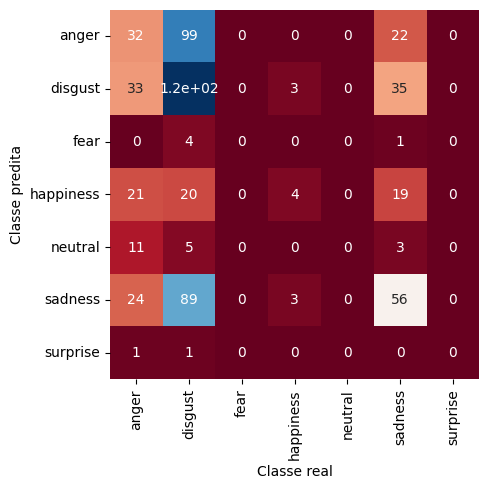

In [132]:
# Matriz de confusão
cm = confusion_matrix(y_test_labels, predicoes)
sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=False,
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.xlabel("Classe real")
plt.ylabel("Classe predita")
plt.show()

##Polaridade Sentimentos

In [181]:
# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(dados_avaliacao['content'], dados_avaliacao['sentiment_polarity'], test_size=0.2, random_state=42)

In [182]:
# Tokenizar os dados dos comentários
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [183]:
# Treinar o modelo Word2Vec
sentences = [sentence.split() for sentence in X_train]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

In [184]:
# Converter comentários para sequências numéricas
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [185]:
# Padronizar as sequências
vocab_size = len(tokenizer.word_index) + 1
max_length = max(max(len(seq) for seq in X_train), max(len(seq) for seq in X_test))
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

In [186]:
# Criar a matriz de embeddings
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [187]:
# Codificar os rótulos
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [188]:
# Converter rótulos para categórico
num_classes = len(label_encoder.classes_)
y_train = np.eye(num_classes)[y_train]
y_test = np.eye(num_classes)[y_test]

In [189]:
# Definir a arquitetura do modelo CNN
model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [190]:
# Compilar o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [191]:
# Treinar o modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
76/76 [==============================] - 3s 25ms/step - loss: 0.7860 - accuracy: 0.5515 - val_loss: 0.7926 - val_accuracy: 0.5738
Epoch 2/10
76/76 [==============================] - 2s 32ms/step - loss: 0.7618 - accuracy: 0.5752 - val_loss: 0.7781 - val_accuracy: 0.5738
Epoch 3/10
76/76 [==============================] - 3s 37ms/step - loss: 0.7617 - accuracy: 0.5806 - val_loss: 0.7809 - val_accuracy: 0.5672
Epoch 4/10
76/76 [==============================] - 2s 22ms/step - loss: 0.7504 - accuracy: 0.5810 - val_loss: 0.7771 - val_accuracy: 0.5738
Epoch 5/10
76/76 [==============================] - 2s 23ms/step - loss: 0.7497 - accuracy: 0.5855 - val_loss: 0.7883 - val_accuracy: 0.5721
Epoch 6/10
76/76 [==============================] - 2s 23ms/step - loss: 0.7528 - accuracy: 0.5847 - val_loss: 0.7840 - val_accuracy: 0.5788
Epoch 7/10
76/76 [==============================] - 2s 23ms/step - loss: 0.7394 - accuracy: 0.5793 - val_loss: 0.8042 - val_accuracy: 0.4909
Epoch 8/10
76

In [192]:
# Fazer previsões
predicoespolarity = np.argmax(model.predict(X_test), axis=1)
y_test_labels = np.argmax(y_test, axis=1)

19/19 [==============================] - 0s 8ms/step


In [193]:
# Relatório de classificação
print(classification_report(y_test_labels, predicoespolarity, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.58      0.94      0.72       346
     neutral       0.00      0.00      0.00        19
    positive       0.53      0.11      0.18       238

    accuracy                           0.58       603
   macro avg       0.37      0.35      0.30       603
weighted avg       0.54      0.58      0.48       603



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


O modelo tem um desempenho  geral moderado, ficou próximo de resultados com o modelo KNN, porém não superou nenhum dos outros modelos


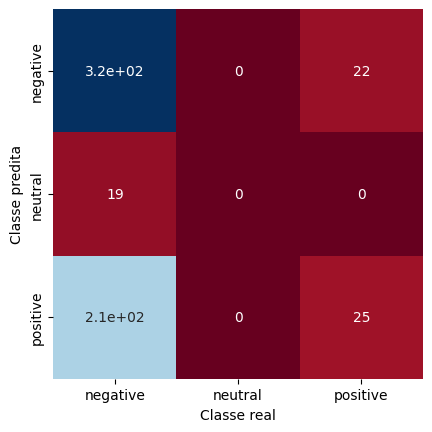

In [194]:
# Matriz de confusão
cm = confusion_matrix(y_test_labels, predicoespolarity)
sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=False,
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.xlabel("Classe real")
plt.ylabel("Classe predita")
plt.show()

##Vantagens e Limitações

Vantagens:

Captura de Relações Semânticas;
Representações Ricas de Texto;
Escalabilidade.

Limitações:

Requisitos Computacionais;
Depende de Grandes Volumes de Dados;
Complexidade de Implementação, o que pode ter gerado eficiência tão baixa.
